In [1]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

x_path = "D:\Project_Working"

A_paths  = ['\AlexaControl_crawl-data', '\AlexaF_crawl-data', '\AlexaFS_crawl-data', '\AlexaFY_crawl-data', 
            '\AlexaM_crawl-data', '\AlexaMS_crawl-data', '\AlexaMY_crawl-data', '\AlexaS_crawl-data', '\AlexaY_crawl-data']
F_paths  = ['\FacebookControl_crawl-data', '\FacebookF_crawl-data', '\FacebookFS_crawl-data', '\FacebookFY_crawl-data', 
            '\FacebookM_crawl-data', '\FacebookMS_crawl-data', '\FacebookMY_crawl-data', '\FacebookS_crawl-data', '\FacebookY_crawl-data']

for i in range(len(A_paths)):
    A_paths[i] = x_path + A_paths[i] + '.sqlite'
    F_paths[i] = x_path + F_paths[i] + '.sqlite'

A_Cp, A_Fp, A_FSp, A_FYp, A_Mp, A_MSp, A_MYp, A_Sp, A_Yp  = A_paths

F_Cp, F_Fp, F_FSp, F_FYp, F_Mp, F_MSp, F_MYp, F_Sp, F_Yp  = F_paths

print(A_Yp)

D:\Project_Working\AlexaY_crawl-data.sqlite


# Score Calculations

In [2]:
con = sqlite3.connect(A_Mp)
cur = con.cursor()

cur.execute('SELECT * FROM javascript_cookies')
javascript_cookies = cur.fetchall()
names = [description[0] for description in cur.description]
javascript_cookies.sort(key=lambda x: x[0]) #Sort by id
js_cookies = pd.DataFrame(javascript_cookies, columns=names)

cur.execute('SELECT * FROM site_visits')
site_visits = cur.fetchall()
names = [description[0] for description in cur.description]
site_visits.sort(key=lambda x: x[3]) #Sort by id
site_visits = pd.DataFrame(site_visits, columns=names)
site_ranks = site_visits.drop(columns=['visit_id', 'browser_id'])

cur.execute('SELECT * FROM http_requests')
http_requests = cur.fetchall()
names = [description[0] for description in cur.description]
http_requests.sort(key=lambda x: x[0]) #Sort by id
http_requests = pd.DataFrame(http_requests, columns=names)

cur.execute('SELECT * FROM javascript')
javascript = cur.fetchall()
names = [description[0] for description in cur.description]
javascript.sort(key=lambda x: x[0]) #Sort by id
javascript = pd.DataFrame(javascript, columns=names)

In [3]:
#Listing third parties by occurence
df_h = js_cookies.groupby('host')['host'].count().sort_values(ascending=False)
df_h

host
.adnxs.com          3969
.doubleclick.net    1201
.yahoo.com          1075
.demdex.net          848
.rambler.ru          757
                    ... 
.google.com.sa         1
.google.com.pk         1
.google.com.pe         1
.google.com.mx         1
.newzit.com            1
Name: host, Length: 580, dtype: int64

In [4]:
#Cookie counts per site, descending order
df_x = site_visits.copy()
df_y = js_cookies.copy()
df_z = pd.merge(df_x, df_y, on=['visit_id', 'browser_id'])

series_cookies = df_z.groupby(['site_url'])['host'].count().sort_values(ascending=False)

for site in site_visits['site_url']: #Fill in sites that placed no cookies
    if site not in series_cookies.keys():
        series_cookies = series_cookies.set_value(site, 0)
series_cookies = series_cookies.rename('cookies')

df_cookies = pd.merge(df_x, series_cookies, on='site_url')
df_cookies.set_index('site_rank')

C:\Users\Zee\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


,visit_id,browser_id,site_url,cookies
site_rank,,,,
0,3786485029333300,3404227008,https://www.google.com,1
1,8991797190360622,3404227008,https://www.youtube.com,6
2,8925893721731900,3404227008,https://www.facebook.com,0
3,6740465974739548,3404227008,https://www.baidu.com,7
4,7714114571624403,3404227008,https://www.wikipedia.org,0
...,...,...,...,...
994,701154422870745,3404227008,https://www.battle.net,0
995,3971873587579217,3404227008,https://www.yallakora.com,27
996,6102357607115603,3404227008,https://www.creditkarma.com,1


In [5]:
#Mean cookie count
print("Max:", series_cookies.max(), " Min:", series_cookies.min(), " Mean:", series_cookies.mean())

Max: 610  Min: 0  Mean: 26.575575575575577


In [6]:
#Sites sorted by unique third parties present
series_unique1 = df_z.groupby('site_url').host.nunique().sort_values(ascending=False)
series_unique1 = series_unique1.rename('unique_third_parties')

df_unique1 = pd.merge(site_visits, series_unique1, on='site_url')
df_unique1.set_index('site_rank')

,visit_id,browser_id,site_url,unique_third_parties
site_rank,,,,
0,3786485029333300,3404227008,https://www.google.com,1
1,8991797190360622,3404227008,https://www.youtube.com,2
3,6740465974739548,3404227008,https://www.baidu.com,1
5,911238327159327,3404227008,https://www.qq.com,1
6,2903820911376118,3404227008,https://www.taobao.com,2
...,...,...,...,...
989,4300223483458110,3404227008,https://www.farfetch.com,2
992,3960630677141820,3404227008,https://www.fanfiction.net,1
995,3971873587579217,3404227008,https://www.yallakora.com,6


In [7]:
#Third parties by unique sites present on
series_unique2 = df_z.groupby('host').site_url.nunique().sort_values(ascending=False)
series_unique2

host
.doubleclick.net    233
.adnxs.com          128
.demdex.net          99
.yahoo.com           94
.linkedin.com        57
                   ... 
.spot.im              1
.state.gov            1
.strava.com           1
.subito.it            1
.163.com              1
Name: site_url, Length: 580, dtype: int64

In [8]:
#Listing sites by number of HTTP requests
df_x = site_visits.copy()
df_y = http_requests.copy()
df_r = pd.merge(df_x, df_y, on=['visit_id', 'browser_id'])

df_http = df_r.groupby(['site_url'])['id'].count().sort_values(ascending=False)

for site in site_visits['site_url']: #Fill in sites that used no http requests
    if site not in df_http.keys():
        df_http = df_http.set_value(site, 0)
df_http

site_url
https://www.amazon.in            349
https://www.kknews.cc            336
https://www.dkn.tv               199
https://www.cnbeta.com           155
https://www.chaturbate.com       140
                                ... 
https://www.kizlarsoruyor.com      1
https://www.kinopoisk.ru           1
https://www.kijiji.ca              1
https://www.kickstarter.com        1
https://www.0byv9mgbn0.com         1
Name: id, Length: 999, dtype: int64

In [9]:
df_http.mean()

5.71971971971972

In [10]:
#Listing sites by types of fingerprinting used (864 sites listed, as only 864 sites ran any recorded javascript)
df_x = site_visits.copy()
df_y = javascript.copy()
df_j = pd.merge(df_x, df_y, on=['visit_id', 'browser_id'])

df_j = df_j.groupby(['site_url', 'symbol']).count()

df_new = pd.DataFrame(columns=['site_url', 'Canvas', 'WebRTC', 'AudioContext','type_total'])

count = 0
last_site = ""
for i, row in df_j.iterrows():
    if count == 0:
        new_row = {'site_url':site, 'Canvas':False, 'WebRTC':False, 'AudioContext':False, 'type_total':0}
        df_new = df_new.append(new_row, ignore_index=True)
        
    site = i[0]
    symbol = i[1]
    total = 0
    WebRTC, AudioContext, Canvas = False, False, False
    if "RTCPeerConnection" in symbol:
        WebRTC = True
        total += 1
    if "AudioContext" in symbol or ("Node" in symbol and "HTMLCanvasElement" not in symbol):
        AudioContext = True
        total += 1
    if "CanvasRenderingContext2D" in symbol or "HTMLCanvasElement" in symbol:
        Canvas = True
        total += 1
    
    if site == last_site or last_site == "":
        if (df_new.iloc[-1, df_new.columns.get_loc('Canvas')] == False) and (Canvas == True):
            df_new.iloc[-1, df_new.columns.get_loc('Canvas')] = True
            df_new.iloc[-1, df_new.columns.get_loc('type_total')] += 1
        if (df_new.iloc[-1, df_new.columns.get_loc('WebRTC')] == False) and (WebRTC == True):
            df_new.iloc[-1, df_new.columns.get_loc('WebRTC')] = True
            df_new.iloc[-1, df_new.columns.get_loc('type_total')] += 1
        if (df_new.iloc[-1, df_new.columns.get_loc('AudioContext')] == False) and (AudioContext == True):
            df_new.iloc[-1, df_new.columns.get_loc('AudioContext')] = True
            df_new.iloc[-1, df_new.columns.get_loc('type_total')] += 1
    else:
        new_row = {'site_url':site, 'Canvas':Canvas, 'WebRTC':WebRTC, 'AudioContext':AudioContext, 'type_total':total}
        df_new = df_new.append(new_row, ignore_index=True)
            
    last_site = site
    count += 1

for i, row in site_visits.iterrows(): #Fill in sites that did no fingerprinting
    site = row['site_url']
    site_present = False
    for x in df_new['site_url']:
        if x == site:
            site_present = True
    if site_present == False:
        new_row = {'site_url':site, 'Canvas':False, 'WebRTC':False, 'AudioContext':False, 'type_total':0}
        df_new = df_new.append(new_row, ignore_index=True)
df_new = df_new.drop_duplicates() # google record, index 0, is duplicated
df_new

,site_url,Canvas,WebRTC,AudioContext,type_total
0,https://www.ithome.com,False,False,False,0
1,https://www.11st.co.kr,False,False,False,0
2,https://www.126.com,True,False,True,2
3,https://www.1337x.to,True,False,False,1
4,https://www.163.com,True,False,False,1
...,...,...,...,...,...
995,https://www.eshkol.io,False,False,False,0
996,https://www.myntra.com,False,False,False,0
997,https://www.yadi.sk,False,False,False,0
998,https://www.fazenda.gov.br,False,False,False,0


In [11]:
#List sites in order of types of fingerprinting used
df_finger = df_new.sort_values('type_total', ascending=False)
df_finger

,site_url,Canvas,WebRTC,AudioContext,type_total
582,https://www.ouo.io,True,True,True,3
792,https://www.vnexpress.net,True,True,True,3
172,https://www.corriere.it,True,True,True,3
614,https://www.prnt.sc,True,True,True,3
504,https://www.merdeka.com,True,True,True,3
...,...,...,...,...,...
417,https://www.interia.pl,False,False,False,0
418,https://www.intoday.in,False,False,False,0
419,https://www.intuit.com,False,False,False,0
422,https://www.investopedia.com,False,False,False,0


In [12]:
#Calculate a tracking score for all sites
df_score = pd.merge(df_finger, df_http, on='site_url')
df_score = pd.merge(df_score, series_cookies, on='site_url')
df_score = df_score.rename(columns={'id':'http_requests'})
df_score = df_score.rename(columns={'host':'cookies'})

scores = []
for i, row in df_score.iterrows():
    scores.append((0.5 * row['cookies']) + (3 * row['http_requests']) + (5 * row['type_total']))
    
df_score['scores'] = scores
df_score = pd.merge(df_score, site_ranks, on='site_url')
df_score = df_score.set_index('site_rank').sort_index()
df_score

,site_url,Canvas,WebRTC,AudioContext,type_total,http_requests,cookies,scores
site_rank,,,,,,,,
0,https://www.google.com,False,False,False,0,1,1,3.5
1,https://www.youtube.com,False,False,False,0,65,6,198.0
2,https://www.facebook.com,True,False,False,1,1,0,8.0
3,https://www.baidu.com,False,False,False,0,1,7,6.5
4,https://www.wikipedia.org,False,False,False,0,1,0,3.0
...,...,...,...,...,...,...,...,...
994,https://www.battle.net,False,False,False,0,4,0,12.0
995,https://www.yallakora.com,True,False,False,1,69,27,225.5
996,https://www.creditkarma.com,False,False,False,0,1,1,3.5


In [13]:
print("Mean Tracking Score:", df_score['scores'].mean())
print("% of sites using fingerprinting:", (len([1 for x in df_finger['type_total'] if x != 0])/len(df_finger)) * 100, '%')

Mean Tracking Score: 33.23973973973974
% of sites using fingerprinting: 43.34334334334334 %


In [14]:
sum_canvas, sum_webrtc, sum_audiocontext = 0, 0, 0

for i, row in df_score.iterrows():
    if row['Canvas']:
        sum_canvas += 1
    if row['WebRTC']:
        sum_webrtc += 1
    if row['AudioContext']:
        sum_audiocontext += 1
print("Canvas:", (sum_canvas/999)*100, "%")
print("WebRTC:", (sum_webrtc/999)*100, "%")
print("AudioContext:", (sum_audiocontext/999)*100, "%")

Canvas: 42.74274274274275 %
WebRTC: 6.406406406406406 %
AudioContext: 6.706706706706707 %


In [15]:
ten_top_trackers = series_unique2.head(10)

count = 0
for i, row in site_visits.iterrows():
    for i2, row2 in df_z.loc[df_z['site_url']==row['site_url']].iterrows():
        if row2['host'] in ten_top_trackers:
            count+=1
            break
        
print("Sites with a top 10 tracker present:", count)

Sites with a top 10 tracker present: 348


# Graph Plotting

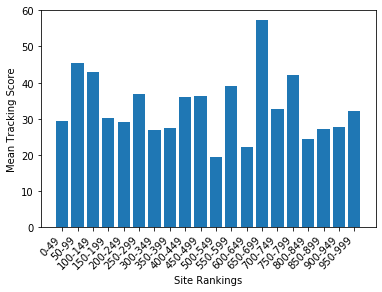

In [16]:
score_chunks = [df_score['scores'][x:x+50] for x in range(0, len(df_score['scores']), 50)] #Group data into an average per 50 sites
score_chunks_mean = [chunk.mean() for chunk in score_chunks] #Get mean score for each chunk
site_chunks = [site_ranks['site_rank'][x:x+50] for x in range(0, len(site_ranks['site_rank']), 50)]
site_chunks_mean = [chunk.mean() for chunk in site_chunks]

chunk_labels = [str(x-50)+'-'+str(x-1) for x in range(1000) if x % 50 == 0 and x != 0]
chunk_labels.append("950-999")

ax = plt.subplot()
plt.bar(np.arange(len(score_chunks_mean)), score_chunks_mean)
plt.xticks(np.arange(len(site_chunks_mean)), chunk_labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel('Site Rankings')
ax.set_ylabel('Mean Tracking Score')
plt.show()

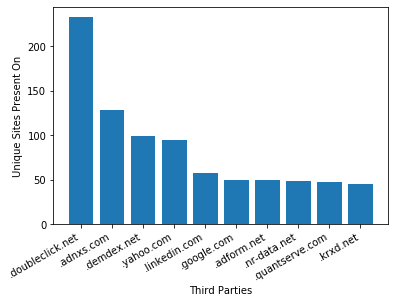

In [17]:
cream = series_unique2.head(10)
ax = plt.subplot()
plt.bar(np.arange(len(cream)), cream)
plt.xticks(np.arange(len(cream)), cream.keys())
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_xlabel('Third Parties')
ax.set_ylabel('Unique Sites Present On')
plt.show()

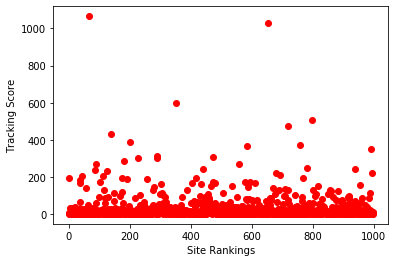

In [18]:
ax = plt.subplot()
plt.scatter(site_ranks['site_rank'], df_score['scores'], c='r')
ax.set_xlabel('Site Rankings')
ax.set_ylabel('Tracking Score')
plt.show()

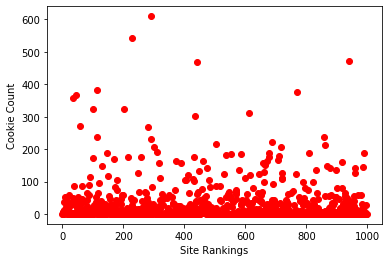

In [19]:
ax = plt.subplot()
plt.scatter(site_ranks['site_rank'], df_score['cookies'], c='r')
ax.set_xlabel('Site Rankings')
ax.set_ylabel('Cookie Count')
plt.show()

In [20]:
df_score.sort_values('scores', ascending=False)

,site_url,Canvas,WebRTC,AudioContext,type_total,http_requests,cookies,scores
site_rank,,,,,,,,
68,https://www.amazon.in,False,False,False,0,349,36,1065.0
655,https://www.kknews.cc,True,False,False,1,336,34,1030.0
351,https://www.dkn.tv,False,False,False,0,199,5,599.5
797,https://www.cnbeta.com,True,False,False,1,155,79,509.5
719,https://www.avgle.com,True,False,True,2,137,111,476.5
...,...,...,...,...,...,...,...,...
599,https://www.lifo.gr,False,False,False,0,1,0,3.0
595,https://www.b3z29k1uxb.com,False,False,False,0,1,0,3.0
594,https://www.lordsfilm.tv,False,False,False,0,1,0,3.0


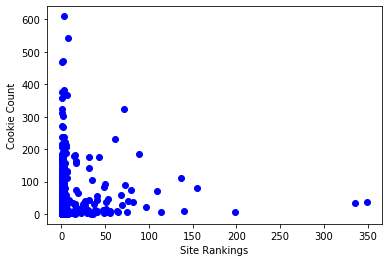

In [27]:
ax = plt.subplot()
plt.scatter(df_score['http_requests'], df_score['cookies'], c='b')
ax.set_xlabel('Site Rankings')
ax.set_ylabel('Cookie Count')
plt.show()